In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

C:\Users\SANDEEP SINGH\anaconda3\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
# Hourly return by timestamp

def hourly_return(df):
    returns = df['close'].pct_change()
    return returns
    

In [3]:
# Volatility

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result


In [4]:
# Max drawdown

def max_drawdown(df):
    max_close = df['close'].groupby(df.token).cummax()
    min_close = df['close'].groupby(df.token).cummin()
    drawdown = (min_close - max_close)/max_close
    return drawdown
    

In [5]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///data/data.db'
#events_db = 'crypto_events_database'

In [6]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "COMP"
connection_string = "sqlite:///data/data.db"


In [7]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [8]:
prices['hourly_returns'] = hourly_return(prices)
prices['volatility'] = vol_ohlc(prices)
prices['max_drawdown'] = max_drawdown(prices)
prices

,open,high,low,close,volume,volumeUSD,token,chain,hourly_returns,volatility,max_drawdown
ts,,,,,,,,,,,
2021-11-29 00:00:00,282.95,288.49,282.95,287.55,1912.208,548951.69991,COMP,ETH,NaN,NaN,0.000000
2021-11-29 01:00:00,287.66,288.67,285.63,286.90,1463.666,420636.11277,COMP,ETH,-0.002260,NaN,-0.002260
2021-11-29 02:00:00,286.90,288.78,286.21,286.66,1250.861,359495.98743,COMP,ETH,-0.000837,NaN,-0.003095
2021-11-29 03:00:00,286.71,287.51,285.12,285.43,318.018,91075.98580,COMP,ETH,-0.004291,NaN,-0.007373
2021-11-29 04:00:00,285.10,286.92,284.67,286.26,632.738,180651.93922,COMP,ETH,0.002908,NaN,-0.007373
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,198.21,201.89,198.21,200.81,884.683,177193.33282,COMP,ETH,0.012811,0.150402,-0.377871
2021-12-12 20:00:00,200.72,201.65,200.21,200.25,543.747,109170.91299,COMP,ETH,-0.002789,0.145145,-0.377871
2021-12-12 21:00:00,200.35,201.67,200.06,200.85,711.909,143058.07740,COMP,ETH,0.002996,0.140901,-0.377871


### Plots in a 2x2 grid

In [9]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

In [10]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    

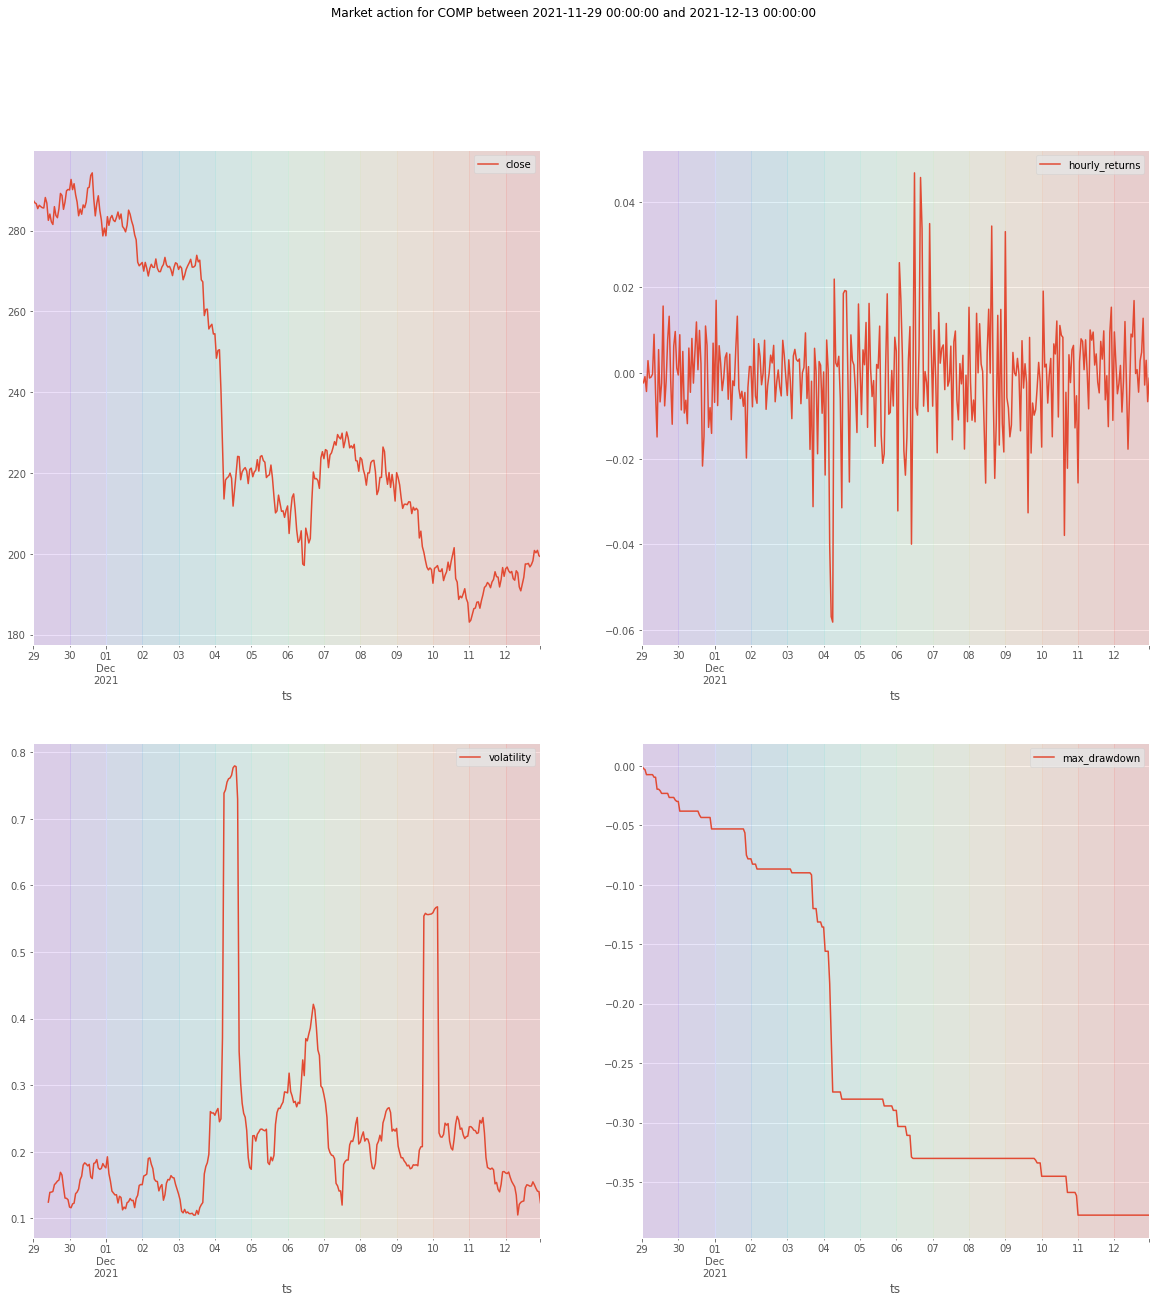

In [11]:
series_plot(prices[['close']], ax=ax[0, 0])
series_plot(prices[['hourly_returns']], ax=ax[0, 1])
series_plot(prices[['volatility']], ax=ax[1, 0])
series_plot(prices[['max_drawdown']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

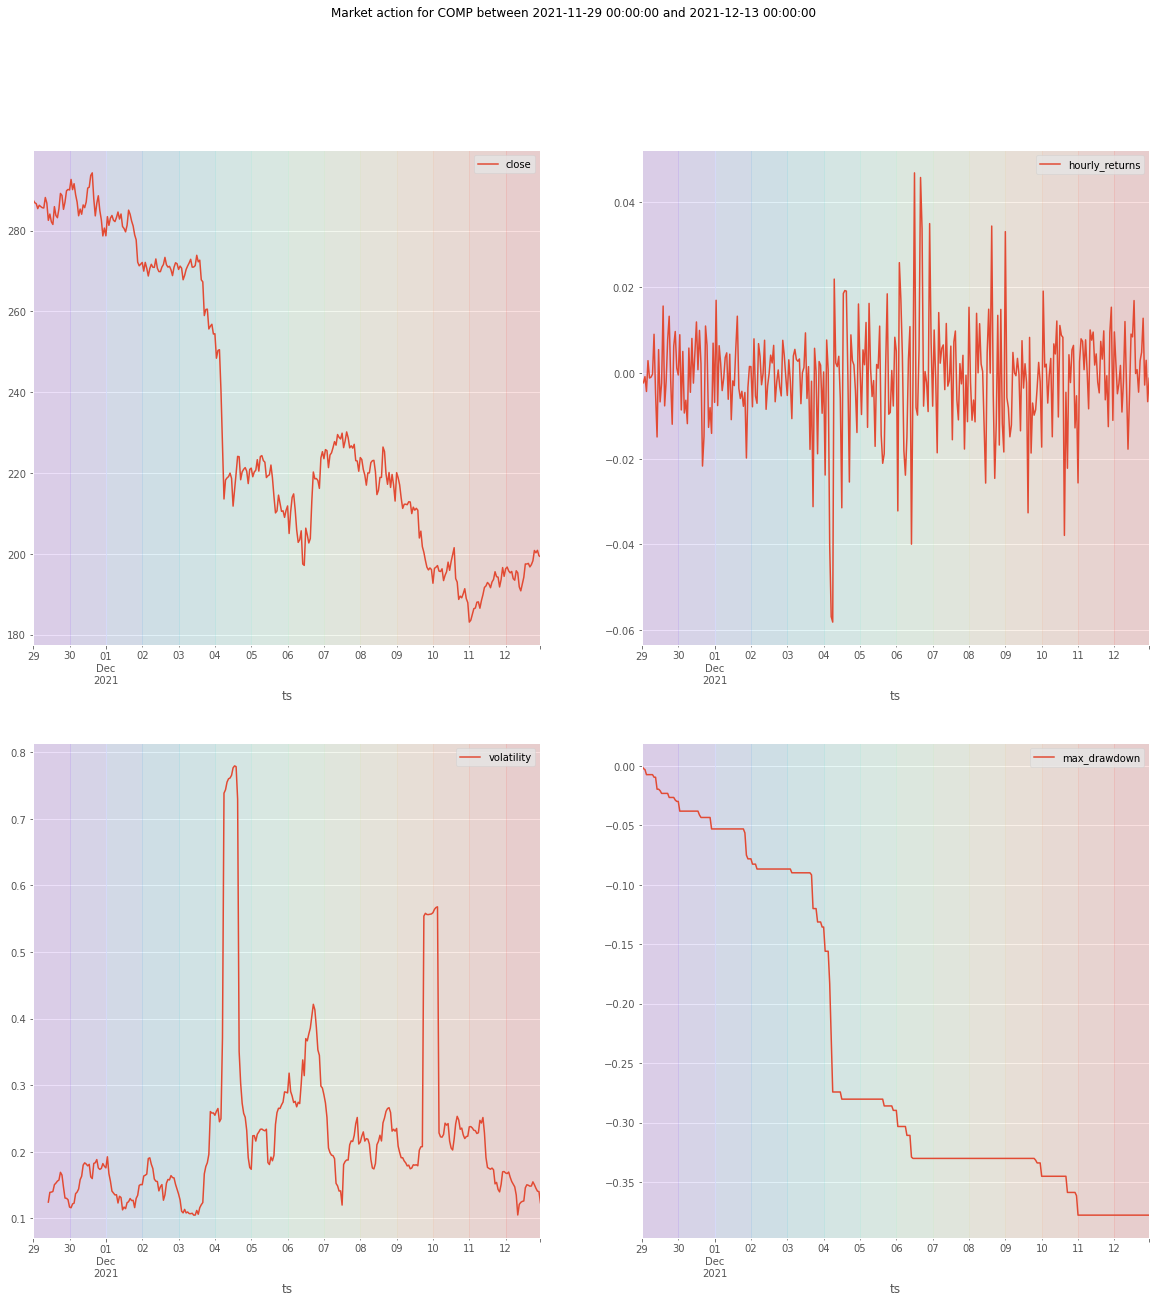

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)